## Customer Churn Model: Building machine learning models on Azure Databricks Managed MLflow
###### Azure-Databricks-MLops-using-MLflow: an end-to-end example

Now that we've ingested and processed our customer data, we want to understand what makes one customer more likely to churn than another, and ultimately see if we can produce a machine learning model that can accurately predict if a given customer will churn or not.

For a data science team charged with creating this model, they will usually undergo a set of key tasks: 

- Exploring data to understand the features available, any interesting patterns that can be found, and its potential for training such model
- Running tools such as a hyperparameter sweep to identify the best performing algorithm for the model
- Validating the model against the holdout dataset, and registering the model if its performance is sustained over the unseen data
- Deploying the model to production and to be used against real-world data - in this case, our full customer base to identify churn candidates and take preventive actions

###### In this notebook, build a model to predict customer churn

#### Requirements

In [ ]:
%pip install --upgrade cloudpickle xgboost mlflow azureml azure-ai-ml azureml-mlflow azureml-core azureml-sdk[databricks]
%pip install xgboost==0.90

Python interpreter will be restarted.
  Created wheel for fusepy: filename=fusepy-3.0.1-py3-none-any.whl size=10503 sha256=6297c8e396788bf01554c652af3f25e4af399ea930121375f90faec63b4cc520
  Stored in directory: /root/.cache/pip/wheels/d5/60/5d/807081f971b004ab5c86eba746c6b5e72d0258215bf2425d68
  Created wheel for strictyaml: filename=strictyaml-1.6.2-py3-none-any.whl size=123940 sha256=702cbe042fbdfae8f4db0303676c4b0ee6f555e5810bd394200efea5ff941fa9
  Stored in directory: /root/.cache/pip/wheels/2a/59/c1/82ec8da49fe5abc15183319250589e7a0efe43ed02b1e6c555
Successfully built fusepy strictyaml
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Not uninstalling cryptography at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d9299016-f16d-402c-bab3-2dba3b6bf554
    Can't uninstall 'cryptography'. No files were found to uninstall.
  Attempting uninstall: cloudpickle
    Found existing in

In [ ]:
#Saving some variables for later use in the notebook. These will be unique to your lab instance
aml_workspace_name = "#AML_WORKSPACE_NAME#"
subscription_id = "#SUBSCRIPTION_ID#"
aml_resource_group ="#RESOURCE_GROUP_NAME#"
location ="#LOCATION#"
databricks_token= "#DATABRICKS_TOKEN#"
workspace_model_url = 'https://#WORKSPACE_URL#/model/retail_churn_model/Production/invocations'

# Set Environment Variables for Authentication
# Setup a new service principal with "Contributor Access" on Azure ML and set the environment variables below
import os
os.environ["AZURE_TENANT_ID"] = "#TENANT_ID#"
os.environ["AZURE_CLIENT_ID"] = "#APP_ID#"
os.environ["AZURE_CLIENT_SECRET"] = "#APP_SECRET#"

In [ ]:
# Loading required packages
import cloudpickle
import time
import json
import numpy as np
import pandas as pd
from math import exp
import xgboost as xgb

# Loading MLflow libraries
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

# Loading packages for building a Machine Learning pipeline
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Loading packages for hyperparameter tuning
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

# Loading libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Import Data
The customer churn data is coming from Teradata (external storage) to Azure data lake storage (ADLS) Gen 2. We are then loading customer subscription data to Azure Databricks Delta table.  

Spark SQL also includes a cost-based optimizer, columnar storage, and code generation to make queries fast. At the same time, it scales to thousands of nodes and multi-hour queries using the Spark engine, which provides full mid-query fault tolerance, without having to worry about using a different engine for historical churn data.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, DecimalType
churnSchema = StructType([    
    StructField("CustomerID",StringType(),True),
    StructField("Gender",StringType(),True),
    StructField("SeniorCitizen",IntegerType(),True),   
    StructField("Partner",StringType(),True),    
    StructField("Dependents",StringType(),True),
    StructField("tenure_month",IntegerType(),True),
    StructField("Discount",StringType(),True),
    StructField("OutletSize",StringType(),True), 
    StructField("OnlineDelivery",StringType(),True),  
    StructField("OrderStatus",StringType(),True),   
    StructField("CustomerSupport",StringType(),True),    
    StructField("Brand",StringType(),True),    
    StructField("StoreContract",StringType(),True),    
    StructField("PaperlessBilling",StringType(),True), 
    StructField("PaymentMethod",StringType(),True), 
    StructField("UnitPrice",DecimalType(),True),   
    StructField("TotalAmount",DecimalType(),True),    
    StructField("Churn",StringType(),True)])


spark_df = spark.read.format("csv").option("header",True).schema(churnSchema).load("/mnt/data-source/Customer Churn Data/CustomerChurnData.csv")
display(spark_df.select("*"))

CustomerID,Gender,SeniorCitizen,Partner,Dependents,tenure_month,Discount,OutletSize,OnlineDelivery,OrderStatus,CustomerSupport,Brand,StoreContract,PaperlessBilling,PaymentMethod,UnitPrice,TotalAmount,Churn
7590-VHVEG,Female,0,Yes,No,1,No,Big,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,30,30,No
5575-GNVDE,Male,0,No,No,34,Yes,Medium,Yes,Shipped,No,Local,One year,No,Mailed check,57,1890,No
3668-QPYBK,Male,0,No,No,2,Yes,Medium,Yes,Shipped,No,Local,Month-to-month,Yes,Mailed check,54,108,Yes
7795-CFOCW,Male,0,No,No,45,No,Big,Yes,Shipped,Yes,Local,One year,No,Bank transfer (automatic),42,1841,No
9237-HQITU,Female,0,No,No,2,Yes,Medium,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,71,152,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Electronic check,100,821,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Credit card (automatic),89,1949,No
6713-OKOMC,Female,0,No,No,10,No,Big,Yes,Shipped,No,Local,Month-to-month,No,Mailed check,30,302,No
7892-POOKP,Female,0,Yes,No,28,Yes,Small,No,Shipped,Yes,National,Month-to-month,Yes,Electronic check,105,3046,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,Medium,Yes,Shipped,No,Local,One year,No,Bank transfer (automatic),56,3488,No


#### Data Preparation

Databricks DataFrames can easily be converted to the popular Pandas dataframes. With [Pandas on Spark](https://learn.microsoft.com/en-us/azure/databricks/languages/pandas-spark) you can even leverage the same Pandas code you know and love with Spark APIs for processing large datasets. Here we have used Pandas to quickly clean our input dataset further by removing errors, null values, and adjusting inconsistent column values.

In [ ]:
# convert to pandas
df = spark_df.toPandas()
# dropping customer ids from df
df.drop('CustomerID', axis=1, inplace=True)

# Convert datatypes as required
df['TotalAmount'] = pd.to_numeric(df['TotalAmount'], errors="coerce")
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors="coerce")
df['tenure_month'] = pd.to_numeric(df['tenure_month'], errors="coerce")
#df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='Male' else 1)
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 'No' if x==0 else 'Yes')

# remove rows with null value in Total Amount
df.drop(df[df['TotalAmount'].isnull()].index, inplace=True)
df.reset_index(drop=True, inplace=True)
display(df)

/databricks/spark/python/pyspark/sql/pandas/utils.py:91: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [UnitPrice, TotalAmount] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


Gender,SeniorCitizen,Partner,Dependents,tenure_month,Discount,OutletSize,OnlineDelivery,OrderStatus,CustomerSupport,Brand,StoreContract,PaperlessBilling,PaymentMethod,UnitPrice,TotalAmount,Churn
Female,No,Yes,No,1,No,Big,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,30.0,30.0,No
Male,No,No,No,34,Yes,Medium,Yes,Shipped,No,Local,One year,No,Mailed check,57.0,1890.0,No
Male,No,No,No,2,Yes,Medium,Yes,Shipped,No,Local,Month-to-month,Yes,Mailed check,54.0,108.0,Yes
Male,No,No,No,45,No,Big,Yes,Shipped,Yes,Local,One year,No,Bank transfer (automatic),42.0,1841.0,No
Female,No,No,No,2,Yes,Medium,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,71.0,152.0,Yes
Female,No,No,No,8,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Electronic check,100.0,821.0,Yes
Male,No,No,Yes,22,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Credit card (automatic),89.0,1949.0,No
Female,No,No,No,10,No,Big,Yes,Shipped,No,Local,Month-to-month,No,Mailed check,30.0,302.0,No
Female,No,Yes,No,28,Yes,Small,No,Shipped,Yes,National,Month-to-month,Yes,Electronic check,105.0,3046.0,Yes
Male,No,No,Yes,62,Yes,Medium,Yes,Shipped,No,Local,One year,No,Bank transfer (automatic),56.0,3488.0,No


#### Exploratory Data Analysis
Exploratory Data Analysis (EDA) ensures the readiness of the data for Machine Learning and ensures that the data is more usable. Without proper EDA, Machine Learning algorithms might not perform as expected, if at all.

Below graph explain that customers who are spending less amount and have short term relationship, have high chances to became Churn.

Out[5]: <matplotlib.legend.Legend at 0x7f8eb0fe6700>

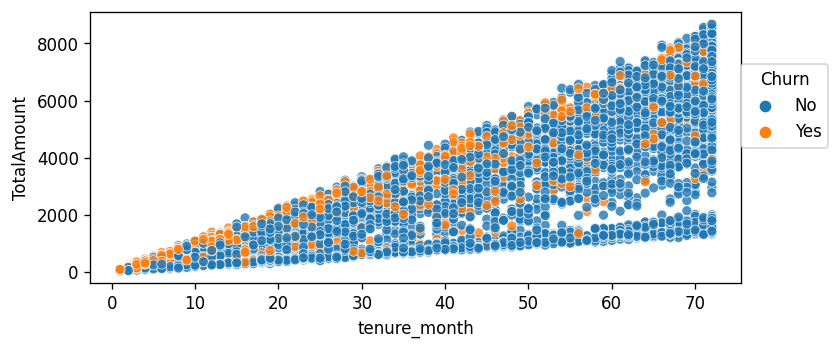

In [ ]:
# Churn rate with tenure and Total amount spend
plt.figure(figsize=(7,3),dpi=120)
sns.scatterplot(data=df,x='tenure_month',y='TotalAmount',hue='Churn',alpha=0.8)
plt.legend(loc=(1,0.5),title = "Churn")

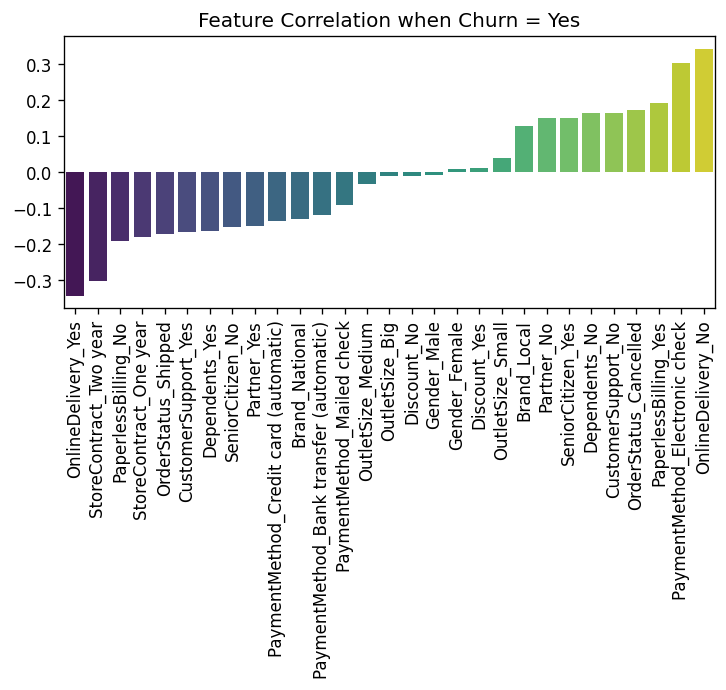

In [ ]:
# Feature Correlation
df_corr  = pd.get_dummies(df[['Gender', 'SeniorCitizen', 'Partner', 'Dependents','Discount', 'OutletSize', 'OnlineDelivery',
       'OrderStatus', 'CustomerSupport', 'Brand', 'StoreContract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

# Feature Correlation when Churn = Yes
plt.figure(figsize=(7,3),dpi=120)
sns.barplot(x=df_corr['Churn_Yes'].sort_values().iloc[1:-2].index,y=df_corr['Churn_Yes'].sort_values().iloc[1:-2].values,palette='viridis')
plt.title('Feature Correlation when Churn = Yes')
plt.xticks(rotation=90);

#### Split data
Prior to training a model, split the data into training and testing sets.

Prepare dataset for training baseline model Split the input data into 2 sets: 
- Train (75% of the dataset used to train the model) 
- Test (25% of the dataset used to report the true performance of the model on an unseen dataset)

In [ ]:
# Encoding churn as 0 and 1, Churn = 1 and Not churn = 0
df['Churn'] = df['Churn'].apply(lambda x: 0 if x=='No' else 1)

# separating dependent and independent variables
X= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int64')
y= df['Churn']

# Split out the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Build a baseline model

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model metrics, and to save the model for later use.
Train a classifier within the context of an MLflow run, which automatically logs the trained model and many associated metrics and parameters. 

You can supplement the logging with additional metrics such as the model's AUC score on the test dataset.

In [ ]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='base_churn_model'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("base_churn_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)
  

/local_disk0/.ephemeral_nfs/envs/pythonEnv-01eaf995-e1ef-485f-83a0-565712764606/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools

In [ ]:
# check feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False).head()

,importance
tenure_month,0.199022
TotalAmount,0.196487
UnitPrice,0.176447
OnlineDelivery_Yes,0.061228
PaymentMethod_Electronic check,0.037638


#### Register the model in MLflow Model Registry
By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.
The following section shows how to do this programmatically, but you can also register a model using the UI.

In [ ]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "base_churn_model"').iloc[0].run_id
run_id

Out[10]: '99b38d51d1314b35a6eef586ecf2e155'

In [ ]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "retail_churn_model". Try using a different name.
import mlflow
model_name = "retail_churn_model"
model_version = mlflow.register_model(f"runs:/{run_id}/base_churn_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'retail_churn_model' already exists. Creating a new version of this model...
2023/02/03 11:47:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: retail_churn_model, version 3
Created version '3' of model 'retail_churn_model'.


In [ ]:
# Transition a model version to a different stage
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[12]: <ModelVersion: creation_timestamp=1675424851670, current_stage='Production', description='', last_updated_timestamp=1675424873043, name='retail_churn_model', run_id='99b38d51d1314b35a6eef586ecf2e155', run_link='', source='dbfs:/databricks/mlflow-tracking/2734317015726014/99b38d51d1314b35a6eef586ecf2e155/artifacts/base_churn_model', status='READY', status_message='', tags={}, user_id='1258158786798171', version='3'>

In [ ]:
# Load a model stored in Python function format
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.7748144104803494


#### Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [ ]:
X= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int32')
y= df['Churn']

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)
 
# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [ ]:
# Hyperparameters  
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}
 
def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)
 
    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "final_model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='final_churn_model'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=30,
    trials=spark_trials,
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 30/30 [00:47<00:00,  1.59s/trial, best loss: -0.8381350816188543]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.


#### View MLflow runs
To view the logged training runs, click the **Experiment** icon at the upper right of the notebook to display the experiment sidebar. If necessary, click the refresh icon to fetch and monitor the latest runs. 

<img width="500" src="https://docs.databricks.com/_static/images/mlflow/quickstart/experiment-sidebar-icons.png"/>

You can then click the experiment page icon to display the more detailed MLflow experiment page ([Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/tracking#notebook-experiments)). This page allows you to compare runs and view details for specific runs.

<img width="500" src="https://docs.databricks.com/_static/images/mlflow/quickstart/compare-runs.png"/>

#### Search runs to retrieve the best model
Because all of the runs are tracked by MLflow, you can retrieve the metrics and parameters for the best run using the MLflow search runs API to find the tuning run with the highest test AUC.

This tuned model should perform better than the simpler models trained in Part 1. 
The code finds the best performing run and saves the model-to-Model Registry. In this case, AUC is a primary metric, and the best-performing model is selected for production deployment. If the latest model performs better than earlier deployed models, the new model is deployed to the production environment and the old model gets archived. If the latest model gives a lesser AUC score, then the previously deployed model remains in the production environment.

In [ ]:
# Sort runs by their test AUC; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.auc"]))
print('Best Iteration: {}'.format(best_run["metrics.best_iteration"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))

Best Run
AUC: 0.8307241862262145
Best Iteration: 48.0
Max Depth: 9.0
Learning Rate: 0.05881779402919951


#### Compare multiple runs in the UI
As in Part 1, you can view and compare the runs in the MLflow experiment details page, accessible via the external link icon at the top of the **Experiment** sidebar. 

On the experiment details page, click the "+" icon to expand the parent run, then select all runs except the parent, and click **Compare**. You can visualize the different runs using a parallel coordinates plot, which shows the impact of different parameter values on a metric. 

<img width="500" src="https://docs.databricks.com/_static/images/mlflow/quickstart/parallel-plot.png"/>

#### Register new model in the Model Registry

In [ ]:
# best run model version
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/final_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'retail_churn_model' already exists. Creating a new version of this model...
2023/02/03 11:48:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: retail_churn_model, version 4
Created version '4' of model 'retail_churn_model'.


In [ ]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)
 
# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

Out[18]: <ModelVersion: creation_timestamp=1675424923684, current_stage='Production', description='', last_updated_timestamp=1675424945270, name='retail_churn_model', run_id='c8c4bd4a397f4508b9c5fbd345656af9', run_link='', source='dbfs:/databricks/mlflow-tracking/2734317015726014/c8c4bd4a397f4508b9c5fbd345656af9/artifacts/final_model', status='READY', status_message='', tags={}, user_id='1258158786798171', version='4'>

#### Load models
You can also access the results for a specific run using the MLflow API. The code in the following cell illustrates how to load the model trained in a given MLflow run and use it to make predictions.

In [ ]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8355300397219463


#### Model Serving in Databricks Workspace
To productionize the model for low latency predictions, use MLflow Model Serving to deploy the model to an endpoint.

The following code illustrates how to issue requests using a REST API to get predictions from the deployed model.

**Note**: You need a Databricks token to issue requests to your model endpoint. You can generate a token from the User Settings page.

In [ ]:
import os
os.environ["DATABRICKS_TOKEN"] = databricks_token

### Enable Serving
Click Models in the left sidebar and navigate to the registered wine model. Click the serving tab, and then click Enable Serving.

Then, under Call The Model, click the Python button to display a Python code snippet to issue requests. Copy the code into this notebook. It should look similar to the code in the next cell.

######You can use the token to make these requests from outside Databricks notebooks as well.

In [ ]:
# scoring script to predict churn from deployed model
import os
import requests
import numpy as np
import pandas as pd

def create_tf_serving_json(data):
  return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
  url = workspace_model_url
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = {"dataframe_split": dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)}
  #data_json = dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

### Model Prediction
Predicting probability of customer churn using deployed model (served_predictions) and best run trained model (model_evaluations). If we get same probability means the model got deployed successfully and is ready to use this model endpoint for production.

In [ ]:
# Model serving is designed for low-latency predictions on smaller batches of data
data_for_pred= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int32')

adb_response = score_model(data_for_pred)

# Results from the deployed model
adb_prediction = pd.DataFrame.from_dict(adb_response)

adb_prediction['Predicted Churn'] = adb_prediction['predictions'].apply(lambda x: 'Yes' if x>=0.50 else "No")
adb_prediction

adb_result = pd.concat( [df, adb_prediction], axis=1) 
display(adb_result)

Gender,SeniorCitizen,Partner,Dependents,tenure_month,Discount,OutletSize,OnlineDelivery,OrderStatus,CustomerSupport,Brand,StoreContract,PaperlessBilling,PaymentMethod,UnitPrice,TotalAmount,Churn,predictions,Predicted Churn
Female,No,Yes,No,1,No,Big,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,30.0,30.0,0,0.6621482372283936,Yes
Male,No,No,No,34,Yes,Medium,Yes,Shipped,No,Local,One year,No,Mailed check,57.0,1890.0,0,0.05689171701669693,No
Male,No,No,No,2,Yes,Medium,Yes,Shipped,No,Local,Month-to-month,Yes,Mailed check,54.0,108.0,1,0.6041442155838013,Yes
Male,No,No,No,45,No,Big,Yes,Shipped,Yes,Local,One year,No,Bank transfer (automatic),42.0,1841.0,0,0.03042786940932274,No
Female,No,No,No,2,Yes,Medium,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,71.0,152.0,1,0.5772585272789001,Yes
Female,No,No,No,8,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Electronic check,100.0,821.0,1,0.9170840382575989,Yes
Male,No,No,Yes,22,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Credit card (automatic),89.0,1949.0,0,0.2266862541437149,No
Female,No,No,No,10,No,Big,Yes,Shipped,No,Local,Month-to-month,No,Mailed check,30.0,302.0,0,0.040872786194086075,No
Female,No,Yes,No,28,Yes,Small,No,Shipped,Yes,National,Month-to-month,Yes,Electronic check,105.0,3046.0,1,0.6767153739929199,Yes
Male,No,No,Yes,62,Yes,Medium,Yes,Shipped,No,Local,One year,No,Bank transfer (automatic),56.0,3488.0,0,0.014358832500874996,No


<img width="500"  src="https://miro.medium.com/max/1400/1*tm1xnupagxdIA2Xu-BbwQg.jpeg"/>

### Deploy latest MLflow registry Model to Azure ML

Before models can be deployed to Azure ML, you must create or obtain an Azure ML Workspace. The azureml.core.Workspace.get() function will load a workspace of a specified name or create one if it does not already exist. For more information about creating an Azure ML Workspace, see the Azure ML Workspace management documentation.

##### Load an Azure ML Workspace

If you are running outside an Azure ML compute, configure the MLflow tracking URI or MLflow's registry URI to point to the workspace you are working on.

In [ ]:
import os
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()
# Check if given credential can get token successfully.
credential.get_token("https://management.azure.com/.default")

# Setting up MLClient to deploy model on ML studio
ml_client = MLClient(credential=credential,
                     subscription_id=subscription_id, 
                     resource_group_name=aml_resource_group,
                     workspace_name = aml_workspace_name)

#####Get Name of Model

In [ ]:
dbutils.widgets.text(name = "model_name", defaultValue = "retail_churn_model", label = "Model Name")
dbutils.widgets.text(name = "stage", defaultValue = "Production", label = "Stage")
dbutils.widgets.text(name = "phase", defaultValue = "qa", label = "Phase")

model_name = dbutils.widgets.get("model_name")
stage = dbutils.widgets.get("stage")
phase=dbutils.widgets.get("phase")
print(model_name)
print(stage)

retail_churn_model
Production


##### Get the latest version of the model that was put into the production stage

In [ ]:
client = mlflow.tracking.MlflowClient()
latest_model_id = client.get_latest_versions(model_name, stages=[stage])[0].run_id
print(latest_model_id)

c8c4bd4a397f4508b9c5fbd345656af9


In [ ]:
import shutil
model_path=client.download_artifacts(run_id = latest_model_id, path="final_model")

model_path = shutil.copytree(model_path, '"/dbfs/mnt/mlflow_models"', dirs_exist_ok=True) 
model_path

<command-2734317015726063>:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  model_path=client.download_artifacts(run_id = latest_model_id, path="final_model")
Out[27]: '"/dbfs/mnt/mlflow_models"'

In [ ]:
# Indicate to MLflow where we want to deploy
from mlflow.deployments import get_deploy_client

# Get AzureML MLflow tracking uri
azureml_mlflow_uri = ml_client.workspaces.get(aml_workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_mlflow_uri)
mlflow.set_registry_uri(azureml_mlflow_uri)
print(azureml_mlflow_uri)

client = get_deploy_client(azureml_mlflow_uri)

azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/506e86fc-853c-4557-a6e5-ad72114efd2b/resourceGroups/rg-midpwithazurecosmos-prod/providers/Microsoft.MachineLearningServices/workspaces/amlws-midp


##### Register Model in Azure ML 
Ensure your model is registered in Azure Machine Learning registry. Deployment of unregistered models is not supported in Azure Machine Learning. You can register a new model using the MLflow SDK:

In [ ]:
# Creating model in Azure ML
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes
run_model = Model(
    path=model_path,
    name="adb_mlflow_retail_model",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL
)

register=ml_client.models.create_or_update(run_model)
print(register.name)
print(register.version)

Uploading mlflow_models" (0.42 MBs): 100%|██████████| 417263/417263 [00:00<00:00, 8339462.17it/s]


adb_mlflow_retail_model
1


#####Deploy using the MLflow plugin

The MLflow plugin *azureml-mlflow* can deploy models to Azure ML, either to Azure Kubernetes Service (AKS), Azure Container Instances (ACI) and Managed Endpoints for real-time serving.


Deployments can be generated using both the Python SDK for MLflow or MLflow CLI. In both cases, a JSON configuration file can be indicated with the details of the deployment you want to achieve. If not indicated, then a default deployment is done using Azure Container Instances (ACI) and a minimal configuration.

#####Managed Inference Service (MIR) for real-time serving.

In [ ]:
import json
# deployment config
deploy_config = {
   "instance_type": "Standard_DS2_v2",
   "instance_count": 1,
}
#deploy_config = {"computeType": "aci"}
deployment_config_path = "deployment_config.json"
with open(deployment_config_path, "w") as outfile:
   outfile.write(json.dumps(deploy_config))
    
# MLflow requires the deployment configuration to be passed as a dictionary.
config = {"deploy-config-file": deployment_config_path}

# register model name and version
model_name = register.name
model_version = register.version
online_endpoint_name  = 'retail-churn-endpoint'

# define the model path and the name is the service name
# if model is not registered, it gets registered automatically and a name is autogenerated using the "name" parameter below
service = client.create_deployment(
    model_uri=f"models:/{model_name}/{model_version}",
    config=config,
    name=online_endpoint_name,)

# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.provisioning_state)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

.....................................................................................Succeeded
{'retail-churn-endpoint': 100}
https://retail-churn-endpoint.eastus2.inference.ml.azure.com/score


#### Consuming AML model Endpoint

The model we operationalized in previous step can be consumed in any notebook or BI service to generate prediction results. In the following cells, we call the model endpoint and the result from it is written back to the lake in delta format. This output can directly be used in Power BI for visualization using serverless capability.

#### Azure ML real-time Endpoint call

In [ ]:
import json
import ast

data_for_pred= pd.get_dummies(df.drop(['Churn'],axis=1),drop_first=True, dtype='int32')
data_json = data_for_pred.to_dict(orient='split') if isinstance(data_for_pred, pd.DataFrame) else create_tf_serving_json(data_for_pred) 

with open ('test_data.json','w') as f: 
    test_json = {'input_data': data_json}
    json.dump(test_json,f)
    
aml_response = ml_client.online_endpoints.invoke(endpoint_name= online_endpoint_name,request_file='test_data.json')
aml_prediction = pd.DataFrame({
  "ChurnProbability": ast.literal_eval(aml_response),
})

aml_prediction['PredictedChurn'] = aml_prediction['ChurnProbability'].apply(lambda x: 'Yes' if x>=0.50 else "No")

aml_result = pd.concat( [df, aml_prediction], axis=1) 

# create Spark DataFrame
aml_result_spark = spark.createDataFrame(aml_result)
display(aml_result_spark)

Gender,SeniorCitizen,Partner,Dependents,tenure_month,Discount,OutletSize,OnlineDelivery,OrderStatus,CustomerSupport,Brand,StoreContract,PaperlessBilling,PaymentMethod,UnitPrice,TotalAmount,Churn,ChurnProbability,PredictedChurn
Female,No,Yes,No,1,No,Big,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,30.0,30.0,0,0.6621482372283936,Yes
Male,No,No,No,34,Yes,Medium,Yes,Shipped,No,Local,One year,No,Mailed check,57.0,1890.0,0,0.05689171701669693,No
Male,No,No,No,2,Yes,Medium,Yes,Shipped,No,Local,Month-to-month,Yes,Mailed check,54.0,108.0,1,0.6041442155838013,Yes
Male,No,No,No,45,No,Big,Yes,Shipped,Yes,Local,One year,No,Bank transfer (automatic),42.0,1841.0,0,0.03042786940932274,No
Female,No,No,No,2,Yes,Medium,No,Shipped,No,Local,Month-to-month,Yes,Electronic check,71.0,152.0,1,0.5772585272789001,Yes
Female,No,No,No,8,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Electronic check,100.0,821.0,1,0.9170840382575989,Yes
Male,No,No,Yes,22,Yes,Small,No,Shipped,No,National,Month-to-month,Yes,Credit card (automatic),89.0,1949.0,0,0.2266862541437149,No
Female,No,No,No,10,No,Big,Yes,Shipped,No,Local,Month-to-month,No,Mailed check,30.0,302.0,0,0.040872786194086075,No
Female,No,Yes,No,28,Yes,Small,No,Shipped,Yes,National,Month-to-month,Yes,Electronic check,105.0,3046.0,1,0.6767153739929199,Yes
Male,No,No,Yes,62,Yes,Medium,Yes,Shipped,No,Local,One year,No,Bank transfer (automatic),56.0,3488.0,0,0.014358832500874996,No


In [ ]:
aml_result_spark.write.mode("overwrite").format("delta").save("/mnt/delta-files/CustomerChurn Data/customerchurndataprediction") 

In [ ]:
# Ending mlflow season
mlflow.end_run()

# Twitter Sentiment Score Model

**Sentiment analysis** on customer data is a collection of machine learning and AI algorithms for developing intelligent applications that involve Twitter text. These features help you find out what people think of your brand or product by mining Twitter text for clues about positive or negative sentiment, and can associate them with specific aspects of the Twitter text.

The output would be either **Positive, Negative or Neutral**.

In [ ]:
# Loading required libraries
import mlflow
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

### Load Data

Data required to train the model is loaded into Spark Dataframe

In [ ]:
# load data from SQL table
df_loaded = spark.read.format("csv").option("header",True).load('/mnt/data-source/TwitterSentiment/ADBTwitterData.csv')

# Preview data
df_loaded = df_loaded.toPandas()

## Preprocessors
*Text features*: Convert each feature to a fixed-length vector using TF-IDF vectorization. Each column corresponds to one of the top word n-grams
where n is in the range [1, 2].
Term Frequency — Inverse Document Frequency (TFIDF) is a technique for text vectorization based on the Bag of words (BoW) model. It performs better than the BoW model as it considers the importance of the word in a document into consideration.

In [ ]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["twitter_text"]
col_selector = ColumnSelector(supported_cols)

In [ ]:
transformers = []

for col in {'twitter_text'}:
    vectorizer = Pipeline(steps=[
        ("imputer", SimpleImputer(missing_values=None, strategy="constant", fill_value="")),
        # Reshape to 1D since SimpleImputer changes the shape of the input to 2D
        ("reshape", FunctionTransformer(np.reshape, kw_args={"newshape":-1})),
        ("tfidf", TfidfVectorizer(decode_error="ignore", ngram_range = (1, 2), max_features=1024))])

    transformers.append((f"text_{col}", vectorizer, [col]))
    
preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Train - Validation - Test Split
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [ ]:
target_col = "sentiment"
split_X = df_loaded.drop([target_col], axis=1)
split_y = df_loaded[target_col]

# Split out train data
X_train, split_X_rem, y_train, split_y_rem = train_test_split(split_X, split_y, train_size=0.6, random_state=663594782, stratify=split_y)

# Split remaining data equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(split_X_rem, split_y_rem, test_size=0.5, random_state=663594782, stratify=split_y_rem)

## Train classification model (XGboost model)
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/544873084077857/s?orderByKey=metrics.%60val_accuracy_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [ ]:
set_config(display="diagram")

# below set of parameters identified from databricks AutoML runs to select optimal parameters to get best model
xgbc_classifier = XGBClassifier(
  colsample_bytree=0.21229231550668443,
  learning_rate=0.10252160457675814,
  max_depth=4,
  min_child_weight=16,
  n_estimators=1116,
  n_jobs=100,
  subsample=0.5305753578345198,
  verbosity=0,
  random_state=663594782,
)

# ML model pipeline configaration
model = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("classifier", xgbc_classifier),
])

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
pipeline = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])

mlflow.sklearn.autolog(disable=True)
pipeline.fit(X_train, y_train)
X_val_processed = pipeline.transform(X_val)

model

Pipeline(steps=[('column_selector', ColumnSelector(cols=['twitter_text'])),
 ('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('text_twitter_text',
 Pipeline(steps=[('imputer',
 SimpleImputer(fill_value='',
 missing_values=None,
 strategy='constant')),
 ('reshape',
 FunctionTransformer(func=<function reshape at 0x7f2ba115e8b0>,
 kw_args={'newshape': -1})),
 ('tfidf',
 TfidfVectorizer(decode_error='ignore',
 max_features=1024,
 ngram_range=(1,
 2)))]),
 ['twitter_text'])])),
 ('classifier',
 XGBClassifier(colsample_bytree=0.21229231550668443,
 learning_rate=0.10252160457675814, max_depth=4,
 min_child_weight=16, n_estimators=1116,
 n_jobs=100, random_state=663594782,
 subsample=0.5305753578345198, verbosity=0))]) Please rerun this cell to show the HTML repr or trust the notebook. Pipeline Pipeline(steps=[('column_selector', ColumnSelector(cols=['twitter_text'])),
 ('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('text_twitter_text',
 Pipeline(steps=[('imputer',
 SimpleImputer(fill_value='',
 missing_values=None,
 strategy='constant')),
 ('reshape',
 FunctionTransformer(func=<function reshape at 0x7f2ba115e8b0>,
 kw_args={'newshape': -1})),
 ('tfidf',
 TfidfVectorizer(decode_error='ignore',
 max_features=1024,
 ngram_range=(1,
 2)))]),
 ['twitter_text'])])),
 ('classifier',
 XGBClassifier(colsample_bytree=0.21229231550668443,
 learning_rate=0.10252160457675814, max_depth=4,
 min_child_weight=16, n_estimators=1116,
 n_jobs=100, random_state=663594782,
 subsample=0.5305753578345198, verbosity=0))]) ColumnSelector ColumnSelector(cols=['twitter_text']) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('text_twitter_text',
 Pipeline(steps=[('imputer',
 SimpleImputer(fill_value='',
 missing_values=None,
 strategy='constant')),
 ('reshape',
 FunctionTransformer(func=<function reshape at 0x7f2ba115e8b0>,
 kw_args={'newshape': -1})),
 ('tfidf',
 TfidfVectorizer(decode_error='ignore',
 max_features=1024,
 ngram_range=(1,
 2)))]),
 ['twitter_text'])]) text_twitter_text ['twitter_text'] SimpleImputer SimpleImputer(fill_value='', missing_values=None, strategy='constant') FunctionTransformer FunctionTransformer(func=<function reshape at 0x7f2ba115e8b0>,
 kw_args={'newshape': -1}) TfidfVectorizer TfidfVectorizer(decode_error='ignore', max_features=1024, ngram_range=(1, 2)) remainder [] passthrough passthrough XGBClassifier XGBClassifier(colsample_bytree=0.21229231550668443,
 learning_rate=0.10252160457675814, max_depth=4,
 min_child_weight=16, n_estimators=1116, n_jobs=100,
 random_state=663594782, subsample=0.5305753578345198,
 verbosity=0)

In [ ]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(run_name="twitter_sentiment_score_pred") as mlflow_run:
    model.fit(X_train, y_train, classifier__early_stopping_rounds=5, classifier__eval_set=[(X_val_processed,y_val)], classifier__verbose=False)
    
#     # Training metrics are logged by MLflow autologging
#     # Log metrics for the validation set
#     xgbc_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val, prefix="val_")

#     # Log metrics for the test set
#     xgbc_test_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_test, y_test, prefix="test_")

#     # Display the logged metrics
#     xgbc_val_metrics = {k.replace("val_", ""): v for k, v in xgbc_val_metrics.items()}
#     xgbc_test_metrics = {k.replace("test_", ""): v for k, v in xgbc_test_metrics.items()}
#     display(pd.DataFrame([xgbc_val_metrics, xgbc_test_metrics], index=["validation", "test"]))

## Model run id
Generating model run id to predict sentiment score

In [ ]:
# Run id for the generated model
model_run_id = (f"{ mlflow_run.info.run_id }")
print(model_run_id)

fe648ea9d48f4c3da5005281e6651657


Save the generated model_run_id in a view, so that it can be used from another notebook

In [ ]:
# creating a view to load the model run id
val = model_run_id

spark.sql(
    """
       CREATE or REPLACE VIEW  mlview
        AS SELECT "{0}" as value
    """.format(val)
)

Out[10]: DataFrame[]

In [ ]:
mlflow.end_run()

#Campaign Analytics

1. **Usecase               :** Performing Campaign analytics on static campaign data coming from snowflake in azure container.<br/>
2. **Notebook Summary      :** This notebook is a part of campaign analytics application which perform `campaign analytics using various pyspark capability`.<br/>
3. **Notebook Description  :** Performing Campaign Analytics on Azure Container Files.


###Feature List
1. Data Profiling
2. Total Revenue, Total Revenue Target & Profit 
3. Campaign Run by Per Week 
4. Total Profit by Country Per Week
5. Top Loss-Making Campaign 

The bronze data received for processing is already curated. So, we will derive gold tables from bronze tables.

### Import Libraries

In [ ]:
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import mean as _mean
from pyspark.sql.functions import max as _max
from pyspark.sql.functions import min as _min
import pyspark.sql.functions as func
import pyspark.sql.functions as F
from pyspark.sql.functions import *

### Load the Campaign Dataset from database

In [ ]:
# dataset = spark.sql("select * from lakedb.bronze_campaign_data")
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType
campaignSchema = StructType([    
    StructField("Region",StringType(),True),
    StructField("Country",StringType(),True),
    StructField("ProductCategory",StringType(),True),
    StructField("Campaign_ID",IntegerType(),True),    
    StructField("Campaign_Name",StringType(),True),
    StructField("Qualification",StringType(),True),
    StructField("Qualification_Number",StringType(),True),
    StructField("Response_Status",StringType(),True),
    StructField("Responses",FloatType(),True),
    StructField("Cost",FloatType(),True),
    StructField("Revenue",FloatType(),True),
    StructField("ROI",FloatType(),True),
    StructField("Lead_Generation",StringType(),True),
    StructField("Revenue_Target",FloatType(),True),
    StructField("Campaign_Tactic",StringType(),True),
    StructField("Customer_Segment",StringType(),True),
    StructField("Status",StringType(),True),
    StructField("Profit",FloatType(),True),
    StructField("Marketing_Cost",FloatType(),True),
    StructField("CampaignID",IntegerType(),True),
    StructField("CampDate",DateType(),True), 
    StructField("SORTED_ID",IntegerType(),True)])

dataset = spark.read.format("csv").option("header",True).schema(campaignSchema).load("/mnt/data-source/Campaign Data/campaign-data2.csv")
display(dataset)

Region,Country,ProductCategory,Campaign_ID,Campaign_Name,Qualification,Qualification_Number,Response_Status,Responses,Cost,Revenue,ROI,Lead_Generation,Revenue_Target,Campaign_Tactic,Customer_Segment,Status,Profit,Marketing_Cost,CampaignID,CampDate,SORTED_ID
Europe,Germany,null,108,southBeach,NA,NA,Qualified,656.0,191.0,91855.56,13860.0,NA,4658.03,Boomer; GenX; GenY; GenZ,Social,Intent,480.56,747.206,11,2021-11-16,3
South America,Brazil,null,111,futureTech,NA,NA,Active,241.5,191.0,4068.43,17820.0,NA,632.295,Gen Z (2000s - now),TV,Consideration,210.73,958.147,11,2021-04-20,3
North & Central America,USA,null,114,futureTech,NA,NA,Qualified,896.0,191.0,16521.55,13860.0,NA,79542.1,Boomer; GenX; GenY; GenZ,Social,Awareness,-1318.52,23.018,11,2021-09-18,3
North & Central America,USA,null,117,futureTech,NA,NA,Active,162.5,174.0,11957.67,13860.0,NA,129370.0,Baby Boomers (45 ? 60s),Social,Inquiries,1423.07,32.776,11,2021-06-27,3
North & Central America,USA,null,120,southBeach,NA,NA,Qualified,328.0,174.0,45927.78,13860.0,NA,2329.015,Baby Boomers (45 ? 60s),Social,Intent,480.56,747.206,11,2021-03-05,3
Europe,Germany,null,123,SustainableFashion,NA,NA,Active,386.0,191.0,77926.56,9900.0,NA,1970.876,Gen Z (2000s - now),TV,Consideration,-12.09,197.063,11,2021-09-02,3
North & Central America,USA,null,126,fashion,NA,NA,Qualified,314.0,174.0,18951.46,7920.0,NA,97427.0,Boomer; GenX; GenY; GenZ,Social,Awareness,901.51,93.891,11,2021-11-21,3
North & Central America,USA,null,129,outdoor,NA,NA,Qualified,949.0,174.0,35022.18,15840.0,NA,85438.42,Baby Boomers (45 ? 60s),Email,Awareness,1023.06,118.099,11,2021-09-02,3
Asia Pacific,Japan,null,132,futureTech,NA,NA,Active,807.0,191.0,43825.49,1980.0,NA,2240.38,Gen Y (80 ? 2000s),Event,Inquiries,-140.33,563.815,11,2021-12-10,3
South America,Brazil,null,135,futureTech,NA,NA,Active,807.0,191.0,39537.51,15840.0,NA,224604.0,Baby Boomers (45 ? 60s),Event,Inquiries,2073.32,72.556,11,2021-11-22,3


### Data profiling

In [ ]:
print(dataset.printSchema())

root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- Campaign_ID: integer (nullable = true)
 |-- Campaign_Name: string (nullable = true)
 |-- Qualification: string (nullable = true)
 |-- Qualification_Number: string (nullable = true)
 |-- Response_Status: string (nullable = true)
 |-- Responses: float (nullable = true)
 |-- Cost: float (nullable = true)
 |-- Revenue: float (nullable = true)
 |-- ROI: float (nullable = true)
 |-- Lead_Generation: string (nullable = true)
 |-- Revenue_Target: float (nullable = true)
 |-- Campaign_Tactic: string (nullable = true)
 |-- Customer_Segment: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Profit: float (nullable = true)
 |-- Marketing_Cost: float (nullable = true)
 |-- CampaignID: integer (nullable = true)
 |-- CampDate: date (nullable = true)
 |-- SORTED_ID: integer (nullable = true)

None


In [ ]:
summary_df = dataset.select("Cost","Revenue","ROI","Revenue_Target","Profit","Marketing_Cost")
display(summary_df.summary())

summary,Cost,Revenue,ROI,Revenue_Target,Profit,Marketing_Cost
count,39,39,39,39,39,39
mean,173.85897435897436,29477.663417718348,12946.153846153846,90666.44727892753,427.8028165866167,228.07363930726663
stddev,71.15519534957491,27194.642262907902,5778.825511425135,105397.1006357249,756.8778504033472,293.58030538381576
min,1.0,3547.56,1980.0,-7830.29,-1318.52,18.063
25%,156.0,11180.56,7920.0,511.76,-154.9,53.992
50%,191.0,16521.55,13860.0,74060.5,403.4,88.077
75%,230.0,39888.11,17820.0,148121.0,1037.34,272.576
max,270.0,92684.94,19800.0,327114.0,2073.32,993.636


### Total Revenue, Total Revenue Target & Profit

In [ ]:
df = dataset.groupBy("Country","Region").agg(_sum("Revenue").alias("Total_Revenue"), _sum("Revenue_Target").alias("Total_Revenue_Target"),_sum("Profit").alias("Total_Profit"),_max("Cost").alias("Max_Cost"),_min("Cost").alias("Min_Cost"))
display(df)

Country,Region,Total_Revenue,Total_Revenue_Target,Total_Profit,Max_Cost,Min_Cost
USA,North & Central America,424151.5966796875,1391179.9383544922,6866.769981384277,240.0,1.25
Japan,Asia Pacific,125992.16796875,879.56982421875,621.5999908447266,191.0,156.0
Brazil,South America,74245.38110351562,760568.0549926758,3963.6699981689453,230.0,156.0
Germany,Europe,525239.7275390625,1383363.880706787,5232.2698764801025,270.0,1.0


In [ ]:
#saving the result into delta table
df = df.withColumn("Total_Revenue", func.round(df["Total_Revenue"],2)).withColumn("Total_Revenue_Target", func.round(df["Total_Revenue_Target"], 2)).withColumn("Total_Profit", func.round(df["Total_Profit"], 2))

display(df)

Country,Region,Total_Revenue,Total_Revenue_Target,Total_Profit,Max_Cost,Min_Cost
USA,North & Central America,424151.6,1391179.94,6866.77,240.0,1.25
Japan,Asia Pacific,125992.17,879.57,621.6,191.0,156.0
Brazil,South America,74245.38,760568.05,3963.67,230.0,156.0
Germany,Europe,525239.73,1383363.88,5232.27,270.0,1.0


### Window Operations on Event Time  
Aggregations over a sliding event-time window are straightforward with Structured Streaming and are very similar to grouped aggregations. In a grouped aggregation, aggregate values (e.g., counts) are maintained for each unique value in the user-specified grouping column. In case of window-based aggregations, aggregate values are maintained for each window the event-time of a row falls into.

In [ ]:
from pyspark.sql.functions import *

windowedCountsDF = \
  dataset \
    .groupBy(
      "Campaign_Name",
      window("CampDate", "1 week")) \
    .count().orderBy(col("count").desc())

display(windowedCountsDF)

Campaign_Name,window,count
futureTech,"List(2021-12-09T00:00:00.000+0000, 2021-12-16T00:00:00.000+0000)",2
futureTech,"List(2021-06-24T00:00:00.000+0000, 2021-07-01T00:00:00.000+0000)",2
southBeach,"List(2021-01-07T00:00:00.000+0000, 2021-01-14T00:00:00.000+0000)",2
futureTech,"List(2021-04-08T00:00:00.000+0000, 2021-04-15T00:00:00.000+0000)",2
outdoor,"List(2021-09-02T00:00:00.000+0000, 2021-09-09T00:00:00.000+0000)",1
entertainment,"List(2021-08-12T00:00:00.000+0000, 2021-08-19T00:00:00.000+0000)",1
outdoor,"List(2021-02-11T00:00:00.000+0000, 2021-02-18T00:00:00.000+0000)",1
beach,"List(2021-08-05T00:00:00.000+0000, 2021-08-12T00:00:00.000+0000)",1
beach,"List(2021-12-16T00:00:00.000+0000, 2021-12-23T00:00:00.000+0000)",1
southBeach,"List(2021-06-17T00:00:00.000+0000, 2021-06-24T00:00:00.000+0000)",1


### Total Profit by Country Per Week

In [ ]:
tumbling_df = dataset.select("Region","Country", "Cost", "Profit","CampDate") \
                     .groupBy(window(col("CampDate"), "7 days"), col("Country")) \
                     .agg(sum("Profit").alias('Total_Profit'),) \
                            .orderBy(col("window.start"))
display(tumbling_df)

window,Country,Total_Profit
"List(2020-12-31T00:00:00.000+0000, 2021-01-07T00:00:00.000+0000)",USA,-211.72999572753906
"List(2021-01-07T00:00:00.000+0000, 2021-01-14T00:00:00.000+0000)",USA,3435.8699951171875
"List(2021-01-28T00:00:00.000+0000, 2021-02-04T00:00:00.000+0000)",USA,-685.6799926757812
"List(2021-01-28T00:00:00.000+0000, 2021-02-04T00:00:00.000+0000)",Brazil,-395.05999755859375
"List(2021-02-04T00:00:00.000+0000, 2021-02-11T00:00:00.000+0000)",Germany,403.3999938964844
"List(2021-02-11T00:00:00.000+0000, 2021-02-18T00:00:00.000+0000)",USA,-154.89999389648438
"List(2021-02-18T00:00:00.000+0000, 2021-02-25T00:00:00.000+0000)",Germany,31.329999923706055
"List(2021-02-25T00:00:00.000+0000, 2021-03-04T00:00:00.000+0000)",Germany,-64.26000213623047
"List(2021-03-04T00:00:00.000+0000, 2021-03-11T00:00:00.000+0000)",USA,480.55999755859375
"List(2021-03-11T00:00:00.000+0000, 2021-03-18T00:00:00.000+0000)",Germany,-154.89999389648438


### Top Loss-Making Campaign

In [ ]:
loss = dataset.select("Campaign_Name","Profit").filter(F.col("Profit") < 0)
display(loss)

Campaign_Name,Profit
futureTech,-1318.52
SustainableFashion,-12.09
futureTech,-140.33
fashion,-375.7
southBeach,-685.68
outdoor,-359.6
beach,-154.9
outdoor,-154.9
outdoor,-64.26
SustainableFashion,-395.06


In [ ]:
loss = loss.withColumn("Loss_Count", F.when((F.col('Profit') < 0 ) , F.lit(1)).otherwise(F.lit(0)))
loss = loss.groupBy('Campaign_Name').sum('Loss_Count')
display(loss)

Campaign_Name,sum(Loss_Count)
beach,1
SustainableFashion,2
futureTech,5
southBeach,1
outdoor,3
fashion,2


# Sales Forecasting

Once we have run our campaign, we use Sklearn Regression model, operationalized using MLflow and Azure ML, to predict total sales revenue using the post campaign data. We are using the following features: 
- Store (Store Identifier Number)
- Brand (The brand of the product)
- Quantity (Quantity of product purchased)
- Advert (Whether the product had an advertisement or not)
- Price (How much the product costs)

## Pre-requisite
### Run this cell to load the required data into the table

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
#import azureml
#import azureml.core
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.spark
#import mlflow.azureml
from mlflow.deployments import get_deploy_client
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from pyspark.ml.feature import StringIndexer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.types import *
from azureml.core import Workspace
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes
from azure.identity import DeviceCodeCredential

%matplotlib inline

/databricks/python/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load the Dataset from table

In [ ]:
# Load train data
train = spark.sql("SELECT Store, Brand, Quantity, Advert, Price, Revenue FROM `lakedb`.`gold_train`")
train.show(5)

# Load test data
test = spark.sql("SELECT Store, Brand, Quantity, Advert, Price, Revenue FROM `lakedb`.`gold_test`")
test.show(5)

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2734317015726116>:2
      1 # Load train data
----> 2 train = spark.sql("SELECT Store, Brand, Quantity, Advert, Price, Revenue FROM `lakedb`.`gold_train`")
      3 train.show(5)
      5 # Load test data

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/session.py:1119, in SparkSession.sql(self, sqlQuery, **kwargs)
   1117     sqlQuery = formatter.format(sqlQuery, **kwargs)
   1118 try:
-> 1119     return DataFrame(self._jsparkSession.sql(sqlQuery), self)
   1120 f

## Assign column types

In [ ]:
train=train.withColumn("Store",train.Store.cast(StringType()))
train=train.withColumn("Revenue",train.Revenue.cast(DoubleType()))
train=train.withColumn("Price",train.Price.cast(DoubleType()))
train=train.withColumn("Advert",train.Advert.cast(BooleanType()))
train=train.withColumn("Quantity",train.Quantity.cast(DoubleType()))

test=test.withColumn("Store",test.Store.cast(StringType()))
test=test.withColumn("Revenue",test.Revenue.cast(DoubleType()))
test=test.withColumn("Price",test.Price.cast(DoubleType()))
test=test.withColumn("Advert",test.Advert.cast(BooleanType()))
test=test.withColumn("Quantity",test.Quantity.cast(DoubleType()))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726118>:1
----> 1 train=train.withColumn("Store",train.Store.cast(StringType()))
      2 train=train.withColumn("Revenue",train.Revenue.cast(DoubleType()))
      3 train=train.withColumn("Price",train.Price.cast(DoubleType()))

NameError: name 'train' is not defined

## Convert Brand to categorical column

In [ ]:
catCols = ["Brand"]
trainCat = train
testCat = test
for catCol in catCols:
    simodel = StringIndexer(inputCol=catCol, outputCol=catCol + "_numeric", handleInvalid='keep').fit(train)
    trainCat = (
        simodel.transform(trainCat)
        .drop(catCol)
        .withColumnRenamed(catCol + "_numeric", catCol)
    )
    testCat = (
        simodel.transform(testCat)
        .drop(catCol)
        .withColumnRenamed(catCol + "_numeric", catCol)
    )
    
display(trainCat)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726120>:2
      1 catCols = ["Brand"]
----> 2 trainCat = train
      3 testCat = test
      4 for catCol in catCols:

NameError: name 'train' is not defined

## Create feature and label datasets

In [ ]:
#Setup Test/Train datasets
train_df = trainCat.toPandas()
test_df = testCat.toPandas()
test_df = test_df.dropna()

#Separate them into features and label datasets
train_x = train_df.drop(["Store", "Revenue"], axis=1)
train_y = train_df[["Revenue"]]

test_x = test_df.drop(["Store", "Revenue"], axis=1)
test_y = test_df[["Revenue"]]

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726122>:2
      1 #Setup Test/Train datasets
----> 2 train_df = trainCat.toPandas()
      3 test_df = testCat.toPandas()
      4 test_df = test_df.dropna()

NameError: name 'trainCat' is not defined

In [ ]:
resultsPdf = pd.DataFrame()

with mlflow.start_run(run_name="sales_forecasting"):
    
    mlflow.sklearn.autolog()
    # Fit, train, and score the model
    model = RandomForestRegressor(max_depth = 2, n_estimators = 100)
    model.fit(train_x, train_y)
    preds = model.predict(test_x)

    # Get Metrics
    mse = mean_squared_error(test_y, preds)
    r2 = r2_score(test_y, preds)

    # Log Metrics and Model
    mlflow.log_metric('mse', mse)
    mlflow.log_metric('r2', r2)
    mlflow.sklearn.log_model(model, "model")

    # Build Metrics Table
    results = [[mse, r2]]
    runResultsPdf = pd.DataFrame(results, columns =['MSE', 'r2'])
    resultsPdf = resultsPdf.append(runResultsPdf)
    
    #Log the model and get run id
    mlflow.sklearn.log_model(model, "sales_forecasting")
    run_id = mlflow.active_run().info.run_id
  
resultsPdf

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726123>:8
      6 # Fit, train, and score the model
      7 model = RandomForestRegressor(max_depth = 2, n_estimators = 100)
----> 8 model.fit(train_x, train_y)
      9 preds = model.predict(test_x)
     11 # Get Metrics

NameError: name 'train_x' is not defined

## Save, load, or score the Regressor on the test data

In [ ]:
model_uri = "runs:/"+run_id+"/model"

#Create a Spark UDF for the MLFlow model
pyfunc_udf = mlflow.pyfunc.spark_udf(spark, model_uri)

#Load Scoring Data into Spark Dataframe
scoreDf = testCat

#Make Prediction
preds = (scoreDf
           .withColumn('Revenue-prediction', pyfunc_udf("Quantity", "Advert", "Price", "Brand"))
        )
display(preds)
## Registering the model in Mlflow


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726125>:1
----> 1 model_uri = "runs:/"+run_id+"/model"
      3 #Create a Spark UDF for the MLFlow model
      4 pyfunc_udf = mlflow.pyfunc.spark_udf(spark, model_uri)

NameError: name 'run_id' is not defined

## Registering the model in MLflow

In [ ]:
experimentName = "sales-forecast"
model_name = "sales_forecasting"

#Register the model
model_version = mlflow.register_model("runs:/"+run_id+"/model", model_name)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726127>:5
      2 model_name = "sales_forecasting"
      4 #Register the model
----> 5 model_version = mlflow.register_model("runs:/"+run_id+"/model", model_name)

NameError: name 'run_id' is not defined

In [ ]:
#Connect to AzureML client
from azure.identity import DefaultAzureCredential
credential = DefaultAzureCredential()
# Check if given credential can get token successfully.
credential.get_token("https://management.azure.com/.default")

# Setting up MLClient to deploy model on ML studio
ml_client = MLClient(credential=credential,
                     subscription_id=subscription_id, 
                     resource_group_name=aml_resource_group,
                     workspace_name = aml_workspace_name)

azureml_mlflow_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_mlflow_uri)

DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable. The requested identity has not been assigned to this resource.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	AzureCliCredential: Azure CLI not found on path
	AzurePowerShellCredential: PowerShell is not installed
To mitigate this issue, please refer to the troubleshooting guidelines here at https://aka.ms/azsdk/python/identity/defaultazurecredential/troubleshoot.


---------------------------------------------------------------------------
ClientAuthenticationError                 Traceback (most recent call last)
File <command-2734317015726128>:5
      3 credential = DefaultAzureCredential()
      4 # Check if given credential can get token successfully.
----> 5 credential.get_token("https://management.azure.com/.default")
      7 # Setting up MLClient to deploy model on ML studio
      8 ml_client = MLClient(credential=credential,
      9                      subscription_id=subscription_id, 
     10                      resource_group_name=aml_resource_group,
     11                      workspace_name = aml_workspace_name)

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-d9299016-f16d-402c-bab3-2dba3b6bf554/lib/python3.9/site-packages/azure/identity/_credentials/default.py:168, in DefaultAzureCredential.get_token(self, *scopes, **kwargs)
    163     _LOGGER.info(
    164         "%s acquired a token from %s", self.__class__.__name__, self._su

In [ ]:
#Create a tracking client for mlflow model
client = mlflow.tracking.MlflowClient()
model_path = client.download_artifacts(run_id, path="sales_forecasting")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726129>:3
      1 #Create a tracking client for mlflow model
      2 client = mlflow.tracking.MlflowClient()
----> 3 model_path = client.download_artifacts(run_id, path="sales_forecasting")

NameError: name 'run_id' is not defined

## Create model in Azure ML

In [ ]:
# Get AzureML MLflow tracking uri
azureml_mlflow_uri = ml_client.workspaces.get(aml_workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_mlflow_uri)
mlflow.set_registry_uri(azureml_mlflow_uri)

#Deploy client on the uri
client = get_deploy_client(azureml_mlflow_uri)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726131>:2
      1 # Get AzureML MLflow tracking uri
----> 2 azureml_mlflow_uri = ml_client.workspaces.get(aml_workspace_name).mlflow_tracking_uri
      3 mlflow.set_tracking_uri(azureml_mlflow_uri)
      4 mlflow.set_registry_uri(azureml_mlflow_uri)

NameError: name 'ml_client' is not defined

In [ ]:
# Creating model in Azure ML
run_model = Model(
    path=model_path,
    name="sales_forecasting",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL
)

register=ml_client.models.create_or_update(run_model)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726132>:3
      1 # Creating model in Azure ML
      2 run_model = Model(
----> 3     path=model_path,
      4     name="sales_forecasting",
      5     description="Model created from run.",
      6     type=AssetTypes.MLFLOW_MODEL
      7 )
      9 register=ml_client.models.create_or_update(run_model)

NameError: name 'model_path' is not defined

## Deploy the model to a managed endpoint

In [ ]:
deploy_config = {
   "instance_type": "Standard_DS2_v2",
   "instance_count": 1,
}

deployment_config_path = "deployment_config.json"
with open(deployment_config_path, "w") as outfile:
   outfile.write(json.dumps(deploy_config))
    
# MLflow requires the deployment configuration to be passed as a dictionary.
config = {"deploy-config-file": deployment_config_path}
model_name = register.name
model_version = register.version
online_endpoint_name  = 'adb-sales-forecasting-endpoint'

# define the model path and the name is the service name
# if model is not registered, it gets registered automatically and a name is autogenerated using the "name" parameter below
service = client.create_deployment(
    model_uri=f"models:/{model_name}/{model_version}",
    config=config,
    name=online_endpoint_name)

# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.provisioning_state)

# Get the scoring URI
print(endpoint.scoring_uri)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726134>:12
     10 # MLflow requires the deployment configuration to be passed as a dictionary.
     11 config = {"deploy-config-file": deployment_config_path}
---> 12 model_name = register.name
     13 model_version = register.version
     14 online_endpoint_name  = 'adb-sales-forecasting-endpoint'

NameError: name 'register' is not defined

## Fetching predictions from the endpoint

In [ ]:
#First we need to fetch data from after the campaign in order to make a sales forecast
schema = StructType([
    StructField("Quantity", DoubleType()),
    StructField("Advert", IntegerType()),
    StructField("Price", FloatType()),
    StructField("Brand", StringType())

])

predicted_df = spark.read.format("csv").option("header",True).schema(schema).load('/mnt/data-source/Store Transactions Data/SalesDataAfterCampaign.csv').toPandas()

In [ ]:
predicted_df['Advert'] = predicted_df['Advert'].astype(float)
predicted_df = predicted_df.dropna()
test_json = json.loads(predicted_df.to_json(orient='split',index=False))


with open ('json_payload.json','w') as f: 
    json_payload = {'input_data':test_json['data']}
    json.dump(json_payload,f)

predictions = ml_client.online_endpoints.invoke(endpoint_name=online_endpoint_name,deployment_name='adb-sales-forecasting-endpoint',request_file='json_payload.json')
predictions = list(map(float,predictions.strip('][').split(',')))
predicted_df['Predicted_Revenue'] = predictions

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2734317015726137>:10
      7     json_payload = {'input_data':test_json['data']}
      8     json.dump(json_payload,f)
---> 10 predictions = ml_client.online_endpoints.invoke(endpoint_name=online_endpoint_name,deployment_name='adb-sales-forecasting-endpoint',request_file='json_payload.json')
     11 predictions = list(map(float,predictions.strip('][').split(',')))
     12 predicted_df['Predicted_Revenue'] = predictions

NameError: name 'ml_client' is not defined

## Visualize predicted sales revenue

In [ ]:
plt.figure(figsize=(7,3),dpi=120)
ax =sns.lineplot(data=predicted_df['Predicted_Revenue'])
plt.title('Sales forecast using store data after launching the campaign')
ax.set(xlabel='Weeks after campaign was run',ylabel="Predicted Revenue")
sns.set(style='darkgrid',palette='pastel')
plt.show()

<Figure size 840x360 with 0 Axes>

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.9/site-packages/pandas/core/indexes/base.py:3621, in Index.get_loc(self, key, method, tolerance)
   3620 try:
-> 3621     return self._engine.get_loc(casted_key)
   3622 except KeyError as err:

File /databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx:136, in pandas._libs.index.IndexEngine.get_loc()

File /databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx:163, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5198, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5206, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'Predicted_Revenue'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback 

## Writing predictions to file system for further use

In [ ]:
spark_df= spark.createDataFrame(predicted_df)

In [ ]:
spark_df.write.mode("overwrite").format("delta").save("/mnt/delta-files/SalesForecast Data/salespredictiondata") 
mlflow.end_run()